# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from PIL import Image
import torch
import torch.nn as nn
import random 
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
image_directory = "C:\\Users\\eclew\\OneDrive\\Desktop\\Lettuce NPK v2\\FNNPK"
mpk_model_v4 = "C:\\Users\\eclew\\OneDrive\\Desktop\\Lettuce NPK v2\\mpk_model_v4.pth"

In [3]:
# Use GPU if available
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cuda:0'

# Custom Transformation Functions

In [4]:
# Custom class to convert near-white pixels to black and near-black pixels to [64, 64, 64]
class ConvertWhiteAndBlackPixels:
    def __call__(self, img):
        # Ensure the image is in RGB mode
        img = img.convert("RGB")

        # Convert the image to a NumPy array for pixel manipulation
        img_array = np.array(img)

        # Define thresholds
        white_threshold = 160  # Pixels above this threshold in all channels are considered near-white
        black_threshold = 30   # Pixels below this threshold in all channels are considered near-black

        # Create masks
        white_mask = (img_array >= white_threshold).all(axis=-1)  # Near-white mask
        black_mask = (img_array <= black_threshold).all(axis=-1)  # Near-black mask

        # Apply transformations
        img_array[white_mask] = [64, 64, 64]      # Set near-white pixels to black
        img_array[black_mask] = [64, 64, 64]   # Set near-black pixels to [64, 64, 64]

        # Convert the modified array back to a PIL image
        return Image.fromarray(img_array)

In [5]:
# Custom function to only increase ColorJitter parameters 
def positive_color_jitter(img):
    """Apply only positive increases to brightness, contrast, saturation, and hue."""
    # Define fixed increase factors
    contrast_factor = 1 + random.uniform(0, 0.2)    # Contrast: 0-20% increase
    saturation_factor = 1 + random.uniform(0, 0.2)  # Saturation: 0-20% increase

    # Apply transformations one by one
    img = transforms.functional.adjust_contrast(img, contrast_factor)
    img = transforms.functional.adjust_saturation(img, saturation_factor)

    return img


# New function to apply jitter only to non-black (lettuce) pixels
def apply_jitter_to_leaves(img):
    """Apply color jitter only to non-black pixels."""
    # Convert image to numpy array
    img_np = np.array(img)

    # Create a mask for non-black pixels (i.e., lettuce pixels)
    mask = np.any(img_np != [64, 64, 64], axis=-1)

    # Apply jitter to the entire image
    jittered_img = positive_color_jitter(img)

    # Replace only non-black pixels with the jittered version
    img_np[mask] = np.array(jittered_img)[mask]

    # Convert back to PIL image
    return Image.fromarray(img_np)

# Transform Entire Dataset + Test Image

In [6]:
# Transformation Pipeline
transform = transforms.Compose([ConvertWhiteAndBlackPixels(),                                           # Convert background to neutral, 64RGB
                                transforms.Resize((652,649), antialias=True),                           # Resize image to Mod3 input image size
                                transforms.Resize(255, antialias=True),                                 # Resize image based on ResNet-50 recommendation
                                transforms.RandomPerspective(distortion_scale=0.25, p=0.5, fill=64),    # Perform random perspective shift, fill disiplaced pixels with 64RGB
                                transforms.RandomCrop(224),                                             # Randomly crop to 224x224 pixel image 
                                apply_jitter_to_leaves,                                                 # Adjust color levels of the plant
                                transforms.ToTensor(),                                                  # Convert to Tensor object
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # ResNet-50 pixel normalization                                                

# Load Data
dataset = datasets.ImageFolder(image_directory, transform=transform)

print("Classes:", dataset.classes)
print("Class Labels:", [dataset.class_to_idx[c] for c in dataset.classes])
print("Number of Images:", len(dataset.imgs))
print(dataset.imgs[0])  # (Image Path, Class Label)

Classes: ['-K', '-N', '-P', 'FN']
Class Labels: [0, 1, 2, 3]
Number of Images: 208
('C:\\Users\\eclew\\OneDrive\\Desktop\\Lettuce NPK v2\\FNNPK\\-K\\k_1.png', 0)


In [7]:
# Ubiquitous Image Transformations
transform3 = transforms.Compose([ConvertWhiteAndBlackPixels(),                  # Convert white background to black to mimic unit environment
                                transforms.Resize((224,224), antialias=True),   # Resize to 224x224 pixel requirement (ResNet50)
                                apply_jitter_to_leaves,
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])                        # Convert to Tensor object (normalized pixel values)

# Dataset Splits

In [8]:
# Extract labels to stratify by
all_labels = [label for _, label in dataset.imgs]

# Split dataset into 80% training and 20% temp (for val and test) with stratification
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.2, stratify=all_labels, random_state=42
)

# Split temp_indices (20%) evenly into validation and test sets (10% each)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[all_labels[i] for i in temp_indices], random_state=42
)

# Define the subsets using the indices
train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# Check the counts to confirm 80/10/10 split
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 166
Validation set size: 21
Test set size: 21


In [9]:
# Helper function to print class distribution with counts and proportions
def print_class_distribution(labels, title):
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())

    print(f"\n{title}")
    print(f"{'Class':<10}{'Count':<10}{'Proportion':<10}")
    for label, count in class_counts.items():
        proportion = count / total_count
        print(f"{label:<10}{count:<10}{proportion:.2%}")

# Get labels for each subset
train_labels = [all_labels[i] for i in train_indices]
val_labels = [all_labels[i] for i in val_indices]
test_labels = [all_labels[i] for i in test_indices]

# Print class distributions
print_class_distribution(train_labels, "Training Set Class Distribution")
print_class_distribution(val_labels, "Validation Set Class Distribution")
print_class_distribution(test_labels, "Test Set Class Distribution")


Training Set Class Distribution
Class     Count     Proportion
0         57        34.34%
2         53        31.93%
3         10        6.02%
1         46        27.71%

Validation Set Class Distribution
Class     Count     Proportion
1         6         28.57%
0         7         33.33%
2         7         33.33%
3         1         4.76%

Test Set Class Distribution
Class     Count     Proportion
0         8         38.10%
2         6         28.57%
1         6         28.57%
3         1         4.76%


In [10]:
# Create DataLoader for training set with shuffling
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=0, pin_memory=True, shuffle=True)

# Create DataLoader for validation set without a sampler (no shuffling)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, num_workers=0, pin_memory=True, shuffle=False)

# Create DataLoader for test set without a sampler (no shuffling)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, num_workers=0, pin_memory=True, shuffle=False)

# ResNet-50 (Fine-Tuning)

In [11]:
def get_resnet50():
    # Load a pre-trained ResNet-50 model
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    
    # Freeze Layers 1 and 2
    for name, param in model.named_parameters():
        if name.startswith("layer1") or name.startswith("layer2"):
            param.requires_grad = False
        else:
            param.requires_grad = True

    # Customize the final fully connected layer to match desired output classes
    model.fc = nn.Sequential(
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 4),  # Adjust the output layer as needed for class count
        nn.Softmax(dim=1)
    )
    
    return model

In [12]:
model = get_resnet50().to(device)

for child in model.named_children():
    print(child[0])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\eclew/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 24.8MB/s]


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [13]:
loss_function = torch.nn.CrossEntropyLoss()

weight_decay = 1e-4
# Initialize Adam optimizer (momentum + adaptive learning for faster convergence)
optimizer = torch.optim.Adam(
    [
        {"params": model.layer3.parameters(), "lr": 1e-5},  # Set learning rate of Layer 3 to 1e-4
        {"params": model.layer4.parameters(), "lr": 1e-5},  # Set learning rate of Layer 3 to 1e-4
        {"params": model.fc.parameters(), "lr": 3e-4},      # Set learning rate of Fully Connected Layer to 1e-3
    ],
    weight_decay=weight_decay   # Prevent overfitting
)

# Training (Fine-Tuning)

In [14]:
epochs = 40

In [15]:
def finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=None, checkpoint_epochs=5, max_epochs_without_imp=3):
  history = {
      "loss": {
          "train": [],
          "val": []
      },
      "accuracy": {
          "train": [],
          "val": []
      }
  }
  epochs_without_imp = 0
  for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}", end="\t-\t")

    model.train()  # put network in train mode for Dropout and Batch Normalization
    train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
    train_accuracy = torch.tensor(0., device=device)
    for X, y in train_dataloader:
      X = X.to(device)
      y = y.to(device)
      ypred = model(X)
      loss = loss_function(ypred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with torch.no_grad():
        train_loss += loss*train_dataloader.batch_size
        train_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

    history["loss"]["train"].append(train_loss.item()/len(train_dataloader.dataset))
    history["accuracy"]["train"].append(train_accuracy.item()/len(train_dataloader.dataset))
    print(f"train loss: {history['loss']['train'][-1]:.2f}", end=", ")
    print(f"train acc: {history['accuracy']['train'][-1]:.2f}", end="\t-\t")

    if val_dataloader is not None:
      model.eval()
      val_loss = torch.tensor(0., device=device)
      val_accuracy = torch.tensor(0., device=device)
      with torch.no_grad():
        for X, y in val_dataloader:
          X = X.to(device)
          y = y.to(device)
          ypred = model(X)
          loss = loss_function(ypred, y)
          val_loss += loss * val_dataloader.batch_size
          val_accuracy += (torch.argmax(ypred, dim=1) == y).sum()

      history["loss"]["val"].append(val_loss.item()/len(val_dataloader.dataset))
      history["accuracy"]["val"].append(val_accuracy.item()/len(val_dataloader.dataset))
      print(f"val loss: {history['loss']['val'][-1]:.2f}", end=", ")
      print(f"val acc: {history['accuracy']['val'][-1]:.2f}")

    if epoch >= 2 and history["loss"]["train"][-1] >= history["loss"]["train"][-2]:
      epochs_without_imp += 1
    else:
      epochs_without_imp = 0
    if epochs_without_imp >= max_epochs_without_imp:
      break

  return model, history

# Training (Results)

In [16]:
# Train and fine-tune the model
model, history = finetune(model, epochs, train_dataloader, optimizer, loss_function, val_dataloader=val_dataloader)

Epoch 1/40	-	train loss: 1.44, train acc: 0.40	-	val loss: 2.04, val acc: 0.57
Epoch 2/40	-	train loss: 1.37, train acc: 0.39	-	val loss: 1.94, val acc: 0.62
Epoch 3/40	-	train loss: 1.30, train acc: 0.66	-	val loss: 1.81, val acc: 0.76
Epoch 4/40	-	train loss: 1.21, train acc: 0.83	-	val loss: 1.71, val acc: 0.81
Epoch 5/40	-	train loss: 1.12, train acc: 0.83	-	val loss: 1.58, val acc: 0.90
Epoch 6/40	-	train loss: 1.06, train acc: 0.81	-	val loss: 1.49, val acc: 0.81
Epoch 7/40	-	train loss: 1.01, train acc: 0.83	-	val loss: 1.44, val acc: 0.86
Epoch 8/40	-	train loss: 0.96, train acc: 0.91	-	val loss: 1.42, val acc: 0.86
Epoch 9/40	-	train loss: 0.95, train acc: 0.89	-	val loss: 1.38, val acc: 0.90
Epoch 10/40	-	train loss: 0.93, train acc: 0.90	-	val loss: 1.43, val acc: 0.86
Epoch 11/40	-	train loss: 0.91, train acc: 0.89	-	val loss: 1.37, val acc: 0.90
Epoch 12/40	-	train loss: 0.89, train acc: 0.93	-	val loss: 1.40, val acc: 0.86
Epoch 13/40	-	train loss: 0.89, train acc: 0.92	-

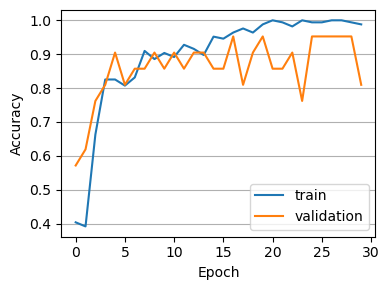

In [17]:
plt.figure(figsize=(4, 3))
plt.plot(history["accuracy"]["train"], label="train")
plt.plot(history["accuracy"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

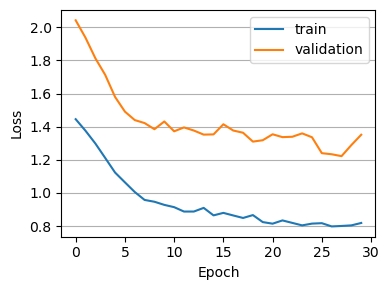

In [18]:
plt.figure(figsize=(4, 3))
plt.plot(history["loss"]["train"], label="train")
plt.plot(history["loss"]["val"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
torch.save(model, mpk_model_v4)

# Test Results

In [20]:
# Load trained model and set to evaluation mode (disable dropout and batch normalization)
saved_model = torch.load(mpk_model_v4)
saved_model.eval()

# Generate predicitions on test set images
with torch.no_grad():
    preds = saved_model(torch.stack([x for x, y in test_set]).to(device)).cpu().detach().numpy()

test_labels = np.array([int(label) for _, label in np.array(dataset.imgs)[test_set.indices]])   # Extract test set ground truth lables 
predicted_labels = np.argmax(preds, axis=1)                                                     # Convert predicted probabiites to corresponding class label
accuracy = len(np.where(test_labels==predicted_labels)[0])/len(test_labels)                     # Calculate test accuracy rate
print("Model accuracy on the test set: {:.2f}".format(accuracy))                                # Print test accuracy rate

Model accuracy on the test set: 0.90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

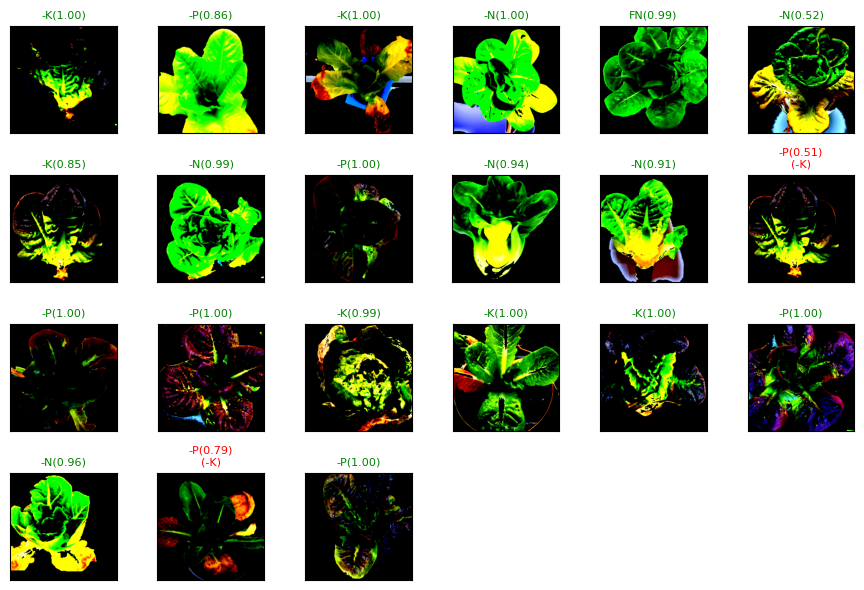

In [21]:
# Create a mapping from class labels to class names
classes = dataset.classes
class_names = dict(zip(range(len(classes)), sorted(classes)))

nrows = 4  # Number of rows for plotting
ncols = 6  # Number of columns for plotting

# Limit the number of images to the smaller of nimgs or the test set size
nimgs = min(nrows * ncols, len(test_set.indices))  # Ensure we don't exceed available images

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))

for i in range(nimgs):
    # Load image and label from the transformed dataset
    img, label = dataset[test_set.indices[i]]
    label = int(label)
    class_name = class_names[label]
    pred_label, confidence = np.argmax(preds[i]), max(preds[i])
    pred_class_name = class_names[pred_label]

    # Adjust tensor shape for plotting: (C, H, W) -> (H, W, C)
    img = torch.moveaxis(img, 0, -1).numpy()

    # Plot transformed image
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(
        f"{pred_class_name}({confidence:.2f})" if pred_label == label else \
        f"{pred_class_name}({confidence:.2f})\n({class_name})",
        fontsize=8, color="green" if pred_label == label else "red"
    )

plt.tight_layout()
plt.show()